In [319]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings

warnings.filterwarnings('ignore')

In [320]:
plt.rcParams['figure.figsize'] = [8, 5]

# Data understanding


In [321]:
np.random.seed(2333)
N = 100000 # number of sample rows in plots
t0 = dt.datetime.now()
train_old = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample_submission = pd.read_csv('./submission.csv')

In [322]:
print('There are {} training rows and {} test rows.'.format(train_old.shape[0], test.shape[0]))
print('There are {} training columns and {} test columns.'.format(train_old.shape[1], test.shape[1]))
train.head(2)

There are 146001 training rows and 30000 test rows.
There are 7 training columns and 6 test columns.


,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration,log_duration,date,pickup_pca0,...,cnt_pickup_hour_center_lat_bin_center_long_bin,avg_speed_h_pickup_hour_pickup_cluster,cnt_pickup_hour_pickup_cluster,avg_speed_h_pickup_hour_dropoff_cluster,cnt_pickup_hour_dropoff_cluster,avg_speed_h_pickup_cluster_dropoff_cluster,cnt_pickup_cluster_dropoff_cluster,pickup_datetime_group,count_60min,dropoff_cluster_count
0,0,-73.783279,40.644718,-73.963799,40.68132,2015-01-09 00:51:48,1815.0,7.504392,2015-01-09,13.578291,...,NaN,33.610356,157.0,NaN,NaN,NaN,NaN,2015-01-09 01:00:00,32.0,0.0
1,0,-73.783279,40.644718,-73.963799,40.68132,2015-01-09 00:51:48,1815.0,7.504392,2015-01-09,13.578291,...,NaN,33.610356,157.0,NaN,NaN,NaN,NaN,2015-01-09 01:00:00,23.0,0.0


In [323]:
# check if there are missing values
print("training set:", train_old.isnull().sum())
print("test set:", test.isnull().sum())

train_nonull = train_old.dropna(how='any', inplace=False)
print("updated:", train_nonull.isnull().sum())

training set: row_id         0
start_lng    400
start_lat      0
end_lng        0
end_lat      600
datetime       0
duration       0
dtype: int64
test set: row_id       0
start_lng    0
start_lat    0
end_lng      0
end_lat      0
datetime     0
dtype: int64
updated: row_id       0
start_lng    0
start_lat    0
end_lng      0
end_lat      0
datetime     0
duration     0
dtype: int64


In [324]:
print("Average trip duration:", train_nonull['duration'].mean())
print("Max. trip duration:", train_nonull['duration'].max())

# elimintate unreasonable duration
# ~1000 column with duration >= 40000
train_nonull.nlargest(5, 'duration') # boundary: 1025

Average trip duration: 1065.8049323797768
Max. trip duration: 42168.0


,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration
15152,15152,-74.008102,40.738548,-73.973732,40.789421,2015-02-01 16:17:12,42168.0
32,32,-73.941292,40.787903,-73.932327,40.794922,2015-04-19 14:53:48,40000.0
162,162,-73.951447,40.774029,-73.977524,40.764542,2015-03-15 00:49:28,40000.0
191,191,-74.007095,40.743675,-73.994583,40.750618,2015-04-04 21:26:13,40000.0
332,332,-73.978447,40.777508,-73.983139,40.781422,2015-06-02 21:18:39,40000.0


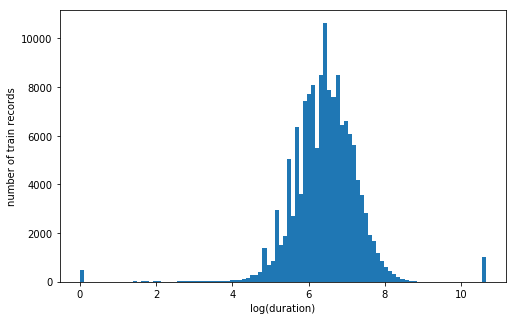

In [325]:
train_nonull['log_duration'] = np.log(train_nonull['duration'].values + 1)
plt.hist(train_nonull['log_duration'].values, bins=100)
plt.xlabel('log(duration)')
plt.ylabel('number of train records')
plt.show()

In [326]:
train_dur = train_nonull.loc[(train_nonull['log_duration'] >= 0.5) & (train_nonull['log_duration'] <= 10)]
print(train_dur.shape[0])

143489


In [327]:
train = train_dur

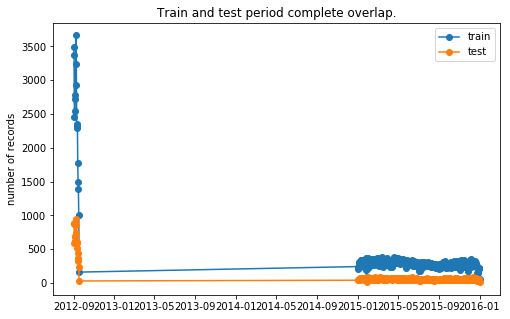

In [328]:
train['datetime'] = pd.to_datetime(train.datetime)
test['datetime'] = pd.to_datetime(test.datetime)
train.loc[:, 'date'] = train['datetime'].dt.date
test.loc[:, 'date'] = test['datetime'].dt.date

# Plot datetime
plt.plot(train.groupby('date').count()[['row_id']], 'o-', label='train')
plt.plot(test.groupby('date').count()[['row_id']], 'o-', label='test')
plt.title('Train and test period complete overlap.')
plt.legend(loc=0)
plt.ylabel('number of records')
plt.show()

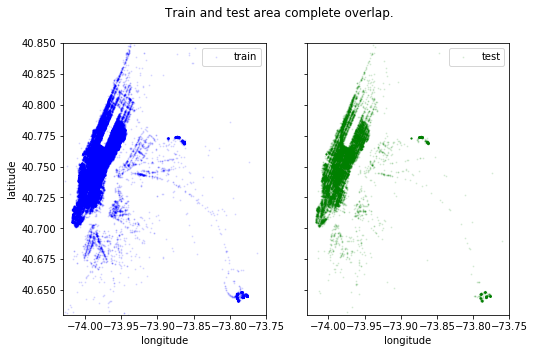

In [329]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['start_lng'].values[:N], train['start_lat'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['start_lng'].values[:N], test['start_lat'].values[:],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

# Feature Extraction

In [330]:
# use PCA to transform longitude and latitude coordinates
coords = np.vstack((train[['start_lat', 'start_lng']].values,
                    train[['end_lat', 'end_lng']].values,
                    test[['start_lat', 'start_lng']].values,
                    test[['end_lat', 'end_lng']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['start_lat', 'start_lng']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['start_lat', 'start_lng']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['end_lat', 'end_lng']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['end_lat', 'end_lng']])[:, 1]
test['pickup_pca0'] = pca.transform(test[['start_lat', 'start_lng']])[:, 0]
test['pickup_pca1'] = pca.transform(test[['start_lat', 'start_lng']])[:, 1]
test['dropoff_pca0'] = pca.transform(test[['end_lat', 'end_lng']])[:, 0]
test['dropoff_pca1'] = pca.transform(test[['end_lat', 'end_lng']])[:, 1]

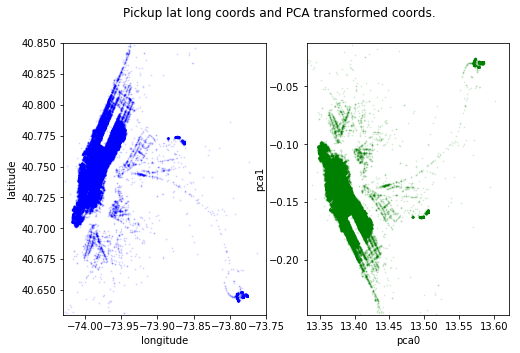

In [331]:
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(train['start_lng'].values[:N], train['start_lat'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(train['pickup_pca0'].values[:N], train['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')
ax[0].set_xlim(city_long_border)
ax[0].set_ylim(city_lat_border)
pca_borders = pca.transform([[x, y] for x in city_lat_border for y in city_long_border])
ax[1].set_xlim(pca_borders[:, 0].min(), pca_borders[:, 0].max())
ax[1].set_ylim(pca_borders[:, 1].min(), pca_borders[:, 1].max())
plt.show()

In [332]:
train.head(2)

,row_id,start_lng,start_lat,end_lng,end_lat,datetime,duration,log_duration,date,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1
0,0,-73.783279,40.644718,-73.963799,40.681320,2015-01-09 00:51:48,1815.0,7.504392,2015-01-09,13.578291,-0.028984,13.399979,-0.075159
1,1,-122.422385,37.789408,-122.419890,37.766692,2012-09-14 01:46:00,300.0,5.707110,2012-09-14,-35.143870,0.228903,-35.142590,0.251719


In [333]:
# Distance Features
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

train.loc[:, 'distance_haversine'] = haversine_array(train['start_lat'].values, train['start_lng'].values, train['end_lat'].values, train['end_lng'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['start_lat'].values, train['start_lng'].values, train['end_lat'].values, train['end_lng'].values)
train.loc[:, 'direction'] = bearing_array(train['start_lat'].values, train['start_lng'].values, train['end_lat'].values, train['end_lng'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

test.loc[:, 'distance_haversine'] = haversine_array(test['start_lat'].values, test['start_lng'].values, test['end_lat'].values, test['end_lng'].values)
test.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(test['start_lat'].values, test['start_lng'].values, test['end_lat'].values, test['end_lng'].values)
test.loc[:, 'direction'] = bearing_array(test['start_lat'].values, test['start_lng'].values, test['end_lat'].values, test['end_lng'].values)
test.loc[:, 'pca_manhattan'] = np.abs(test['dropoff_pca1'] - test['pickup_pca1']) + np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

train.loc[:, 'center_latitude'] = (train['start_lat'].values + train['end_lat'].values) / 2
train.loc[:, 'center_longitude'] = (train['start_lng'].values + train['end_lng'].values) / 2
test.loc[:, 'center_latitude'] = (test['start_lat'].values + test['end_lat'].values) / 2
test.loc[:, 'center_longitude'] = (test['start_lng'].values + test['end_lng'].values) / 2

In [334]:
# Datetime features
train.loc[:, 'pickup_weekday'] = train['datetime'].dt.weekday
train.loc[:, 'pickup_hour_weekofyear'] = train['datetime'].dt.weekofyear
train.loc[:, 'pickup_hour'] = train['datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['datetime'].dt.minute
train.loc[:, 'pickup_dt'] = (train['datetime'] - train['datetime'].min()).dt.total_seconds()
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

test.loc[:, 'pickup_weekday'] = test['datetime'].dt.weekday
test.loc[:, 'pickup_hour_weekofyear'] = test['datetime'].dt.weekofyear
test.loc[:, 'pickup_hour'] = test['datetime'].dt.hour
test.loc[:, 'pickup_minute'] = test['datetime'].dt.minute
test.loc[:, 'pickup_dt'] = (test['datetime'] - train['datetime'].min()).dt.total_seconds()
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + test['pickup_hour']

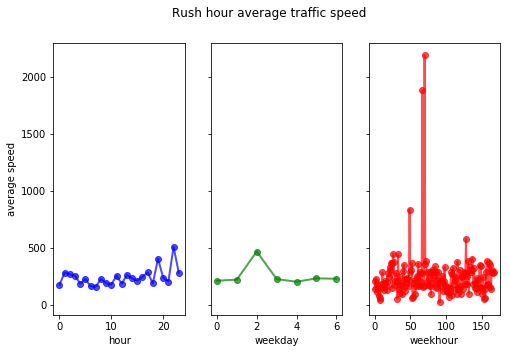

In [335]:
# Speed
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['duration']
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('weekhour')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

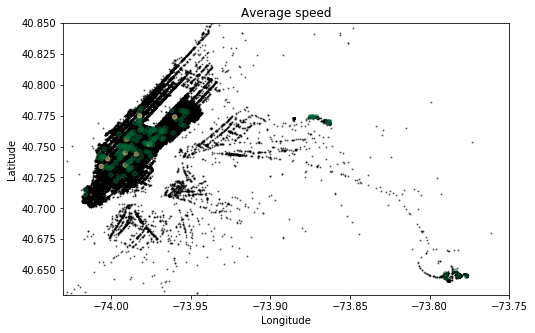

In [336]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['start_lat'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['start_lng'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['row_id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['row_id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.start_lng.values[:N], train.start_lat.values[:N],
           color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values,
           c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

train.loc[:, 'pickup_lat_bin'] = np.round(train['start_lat'], 2)
train.loc[:, 'pickup_long_bin'] = np.round(train['start_lng'], 2)
train.loc[:, 'center_lat_bin'] = np.round(train['center_latitude'], 2)
train.loc[:, 'center_long_bin'] = np.round(train['center_longitude'], 2)
train.loc[:, 'pickup_dt_bin'] = (train['pickup_dt'] // (3 * 3600))
test.loc[:, 'pickup_lat_bin'] = np.round(test['start_lat'], 2)
test.loc[:, 'pickup_long_bin'] = np.round(test['start_lng'], 2)
test.loc[:, 'center_lat_bin'] = np.round(test['center_latitude'], 2)
test.loc[:, 'center_long_bin'] = np.round(test['center_longitude'], 2)
test.loc[:, 'pickup_dt_bin'] = (test['pickup_dt'] // (3 * 3600))

In [337]:
# Clustering
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [338]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['start_lat', 'start_lng']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['end_lat', 'end_lng']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['start_lat', 'start_lng']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['end_lat', 'end_lng']])
t1 = dt.datetime.now()
# print('Time till clustering: %i seconds' % (t1 - t0).seconds)

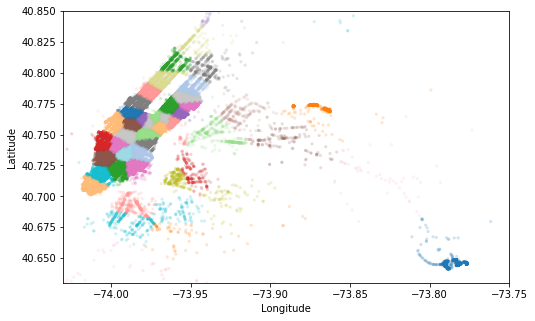

In [339]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.start_lng.values[:N], train.start_lat.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [340]:
for gby_col in ['pickup_hour', 'date', 'pickup_dt_bin',
               'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m', 'log_duration']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=gby_col, right_index=True)

for gby_cols in [['center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'center_lat_bin', 'center_long_bin'],
                 ['pickup_hour', 'pickup_cluster'],  ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['row_id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['row_id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [341]:
test.shape

(30000, 58)

In [349]:
group_freq = '60min'
df_all = pd.concat((train, test))[['row_id', 'datetime', 'pickup_cluster', 'dropoff_cluster']]
train.loc[:, 'pickup_datetime_group'] = train['datetime'].dt.round(group_freq)
test.loc[:, 'pickup_datetime_group'] = test['datetime'].dt.round(group_freq)

# Count trips over 60min
# df_counts = df_all.set_index('datetime')[['row_id']].sort_index()
# df_counts['count_60min'] = df_counts.isnull().rolling(group_freq).count()['row_id']
# train = train.merge(df_counts, on='row_id', how='left')
# test = test.merge(df_counts, on='row_id', how='left')

# Count how many trips are going to each cluster over time
dropoff_counts = df_all \
    .set_index('datetime') \
    .groupby([pd.TimeGrouper(group_freq), 'dropoff_cluster']) \
    .agg({'row_id': 'count'}) \
    .reset_index().set_index('datetime') \
    .groupby('dropoff_cluster').rolling('240min').mean() \
    .drop('dropoff_cluster', axis=1) \
    .reset_index().set_index('datetime').shift(freq='-120min').reset_index() \
    .rename(columns={'datetime': 'pickup_datetime_group', 'row_id': 'dropoff_cluster_count'})

train['dropoff_cluster_count'] = train[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)
test['dropoff_cluster_count'] = test[['pickup_datetime_group', 'dropoff_cluster']].merge(dropoff_counts, on=['pickup_datetime_group', 'dropoff_cluster'], how='left')['dropoff_cluster_count'].fillna(0)

In [350]:
test.shape

(30000, 60)

In [219]:
# OSRM Features
train_street_info = pd.read_csv('./osrm_train.csv',
                  usecols=['row_id', 'total_distance', 'total_travel_time',  'number_of_steps'])
test_street_info = pd.read_csv('./osrm_test.csv',
                               usecols=['row_id', 'total_distance', 'total_travel_time', 'number_of_steps'])
train = train.merge(train_street_info, how='left', on=['row_id'])
test = test.merge(test_street_info, how='left', on=['row_id'])
train_street_info.head()

ValueError: Usecols do not match columns, columns expected but not found: ['total_distance']

In [289]:
test.shape

(59463, 62)

In [351]:
feature_names = list(train.columns)
print(np.setdiff1d(train.columns, test.columns))
do_not_use_for_training = ['row_id', 'log_duration', 'datetime', 'date',
                           'pickup_date', 'avg_speed_h', 'avg_speed_m', 'duration',
                           'pickup_lat_bin', 'pickup_long_bin',
                           'center_lat_bin', 'center_long_bin',
                           'pickup_dt_bin', 'pickup_datetime_group']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
# print(feature_names)
print('We have %i features.' % len(feature_names))
train[feature_names].count()
y = np.log(train['duration'].values + 1)

t1 = dt.datetime.now()
# print('Feature extraction time: %i seconds' % (t1 - t0).seconds)

['avg_speed_h' 'avg_speed_m' 'duration' 'log_duration']
We have 51 features.


In [352]:
feature_stats = pd.DataFrame({'feature': feature_names})
feature_stats.loc[:, 'train_mean'] = np.nanmean(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_mean'] = np.nanmean(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_std'] = np.nanstd(train[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'test_std'] = np.nanstd(test[feature_names].values, axis=0).round(4)
feature_stats.loc[:, 'train_nan'] = np.mean(np.isnan(train[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'test_nan'] = np.mean(np.isnan(test[feature_names].values), axis=0).round(3)
feature_stats.loc[:, 'train_test_mean_diff'] = np.abs(feature_stats['train_mean'] - feature_stats['test_mean']) / np.abs(feature_stats['train_std'] + feature_stats['test_std'])  * 2
feature_stats.loc[:, 'train_test_nan_diff'] = np.abs(feature_stats['train_nan'] - feature_stats['test_nan'])
feature_stats = feature_stats.sort_values(by='train_test_mean_diff')
feature_stats[['feature', 'train_test_mean_diff']].tail()

,feature,train_test_mean_diff
37,avg_speed_h_gby_dropoff_cluster,0.210500
38,avg_speed_m_gby_dropoff_cluster,0.210507
11,pca_manhattan,0.226078
9,distance_dummy_manhattan,0.235227
8,distance_haversine,0.235515


In [353]:
feature_stats = feature_stats.sort_values(by='train_test_nan_diff')
feature_stats[['feature', 'train_nan', 'test_nan', 'train_test_nan_diff']].tail()

,feature,train_nan,test_nan,train_test_nan_diff
46,avg_speed_h_pickup_hour_dropoff_cluster,0.373,0.381,0.008
40,avg_speed_h_center_lat_bin_center_long_bin,0.085,0.072,0.013
41,cnt_center_lat_bin_center_long_bin,0.085,0.072,0.013
45,cnt_pickup_hour_pickup_cluster,0.269,0.288,0.019
44,avg_speed_h_pickup_hour_pickup_cluster,0.269,0.288,0.019


## Model

In [388]:
Xtr, Xv, ytr, yv = train_test_split(train[feature_names].values, y, test_size=30000, random_state=2019)
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)
dtest = xgb.DMatrix(test[feature_names].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [ ]:
FOREVER_COMPUTING_FLAG = True
xgb_pars = []
for MCW in [10, 20, 50, 75, 100]:
    for ETA in [0.05, 0.1, 0.15]:
        for CS in [0.3, 0.4, 0.5]:
            for MD in [6, 8, 10, 12, 15]:
                for SS in [0.5, 0.6, 0.7, 0.8, 0.9]:
                    for LAMBDA in [0.5, 1., 1.5,  2., 3.]:
                        xgb_pars.append({'min_child_weight': MCW, 'eta': ETA, 
                                         'colsample_bytree': CS, 'max_depth': MD,
                                         'subsample': SS, 'lambda': LAMBDA, 
                                         'nthread': -1, 'booster' : 'gbtree', 'eval_metric': 'rmse',
                                         'silent': 1, 'objective': 'reg:linear'})

while FOREVER_COMPUTING_FLAG:
    xgb_par = np.random.choice(xgb_pars, 1)[0]
    print(xgb_par)
    model = xgb.train(xgb_par, dtrain, 2000, watchlist, early_stopping_rounds=50,
                      maximize=False, verbose_eval=100)
    print('Modeling RMSLE %.5f' % model.best_score)

{'min_child_weight': 20, 'eta': 0.15, 'colsample_bytree': 0.5, 'max_depth': 8, 'subsample': 0.8, 'lambda': 3.0, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear'}
[0]	train-rmse:5.08293	valid-rmse:5.07659
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.301316	valid-rmse:0.35609
[200]	train-rmse:0.271324	valid-rmse:0.3541
Stopping. Best iteration:
[224]	train-rmse:0.26569	valid-rmse:0.353843

Modeling RMSLE 0.35384
{'min_child_weight': 20, 'eta': 0.1, 'colsample_bytree': 0.3, 'max_depth': 6, 'subsample': 0.7, 'lambda': 2.0, 'nthread': -1, 'booster': 'gbtree', 'eval_metric': 'rmse', 'silent': 1, 'objective': 'reg:linear'}
[0]	train-rmse:5.38343	valid-rmse:5.37666
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[100]	train-rmse:0.34

In [389]:
# Use the best results from above
xgb_pars = {'min_child_weight': 50, 'eta': 0.3, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': 4, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 1200, watchlist, early_stopping_rounds=50,
                  maximize=False, verbose_eval=10)

[0]	train-rmse:4.20542	valid-rmse:4.19939
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:0.392343	valid-rmse:0.413191
[20]	train-rmse:0.33549	valid-rmse:0.376396
[30]	train-rmse:0.319333	valid-rmse:0.372135
[40]	train-rmse:0.309057	valid-rmse:0.369774
[50]	train-rmse:0.299846	valid-rmse:0.368817
[60]	train-rmse:0.293692	valid-rmse:0.369057
[70]	train-rmse:0.288265	valid-rmse:0.368435
[80]	train-rmse:0.283258	valid-rmse:0.368931
[90]	train-rmse:0.278869	valid-rmse:0.369554
[100]	train-rmse:0.273332	valid-rmse:0.370127
Stopping. Best iteration:
[56]	train-rmse:0.295985	valid-rmse:0.368179



In [390]:
print('Modeling RMSLE %.5f' % model.best_score)
# t1 = dt.datetime.now()
# print('Training time: %i seconds' % (t1 - t0).seconds)

Modeling RMSLE 0.36818


### Feature importance analysis

In [391]:
feature_importance_dict = model.get_fscore()
fs = ['f%i' % i for i in range(len(feature_names))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()),
                   'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': feature_names})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

feature_importance[['feature_name', 'importance']].sort_values(by='importance', ascending=False)

,feature_name,importance
5,direction,845
17,distance_haversine,703
48,distance_dummy_manhattan,665
31,dropoff_pca1,508
28,pickup_pca1,484
2,center_latitude,454
14,pickup_pca0,451
47,pca_manhattan,442
30,dropoff_pca0,431
4,start_lng,417


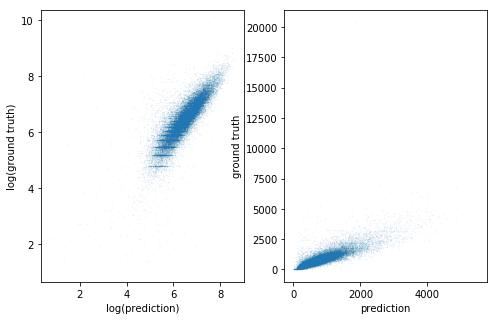

In [392]:
ypred = model.predict(dvalid)
fig,ax = plt.subplots(ncols=2)
ax[0].scatter(ypred, yv, s=0.1, alpha=0.1)
ax[0].set_xlabel('log(prediction)')
ax[0].set_ylabel('log(ground truth)')
ax[1].scatter(np.exp(ypred), np.exp(yv), s=0.1, alpha=0.1)
ax[1].set_xlabel('prediction')
ax[1].set_ylabel('ground truth')
plt.show()

In [395]:
from sklearn.metrics import mean_squared_error
score = np.sqrt(mean_squared_error(np.exp(ypred), np.exp(yv)))
print(score)
print(len(ypred))

319.12430008395415
30000


In [383]:
ytest = model.predict(dtest)
print('Test shape OK.') if test.shape[0] == ytest.shape[0] else print('Oops')
test['duration'] = np.exp(ytest) - 1

Test shape OK.


Valid prediction mean: 6.422
Test prediction mean: 6.420


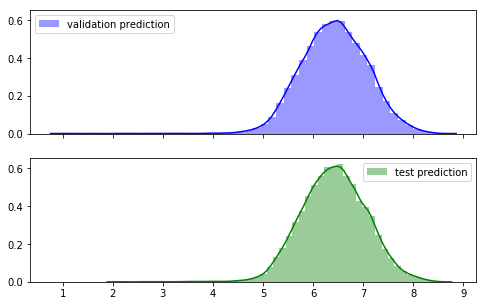

Total time: 1703 seconds


In [386]:
test[['row_id', 'duration']].to_csv('yingying_submission.csv', index=False)

print('Valid prediction mean: %.3f' % ypred.mean())
print('Test prediction mean: %.3f' % ytest.mean())

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
sns.distplot(ypred, ax=ax[0], color='blue', label='validation prediction')
sns.distplot(ytest, ax=ax[1], color='green', label='test prediction')
ax[0].legend(loc=0)
ax[1].legend(loc=0)
plt.show()

t1 = dt.datetime.now()
print('Total time: %i seconds' % (t1 - t0).seconds)